Augustinas Jarockis 2213729

In [5]:
# Initialise classes
classes = ["Ant", "Squirrel", "Cat"]

train_path = "/content/drive/MyDrive/GMM"
test_path = "/content/drive/MyDrive/GMM_Test"

In [6]:
# Mount the drive
from google.colab import drive
import os

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Prepare to download from open images
!pip install openimages

from openimages.download import download_dataset

# Download the files
os.makedirs(train_path, exist_ok=True)

number_for_samples = 660
print("Downloading is starting...")
download_dataset(train_path, classes, limit=number_for_samples)

100%|██████████| 63/63 [00:02<00:00, 23.37it/s]


{'ant': {'images_dir': '/content/drive/MyDrive/GMM/ant/images'},
 'squirrel': {'images_dir': '/content/drive/MyDrive/GMM/squirrel/images'},
 'cat': {'images_dir': '/content/drive/MyDrive/GMM/cat/images'}}

In [ ]:
# Split test and train data

import random
import shutil

def split_train_test(class_name, train_save_path, test_save_path, split_count=60):
    class_folder = os.path.join(train_save_path, class_name.lower(), "images")

    images = [img for img in os.listdir(class_folder) if img.endswith(('.jpg', '.jpeg', '.png'))]
    random.shuffle(images)

    train_images = images[split_count:]
    test_images = images[:split_count]

    for img in train_images:
        old_path = os.path.join(class_folder, img)
        new_class_folder = os.path.join(train_save_path, class_name.lower())
        os.makedirs(new_class_folder, exist_ok=True)
        new_path = os.path.join(new_class_folder, img)
        shutil.move(old_path, new_path)

    for img in test_images:
        old_path = os.path.join(class_folder, img)
        new_class_folder = os.path.join(test_save_path, class_name.lower())
        os.makedirs(new_class_folder, exist_ok=True)
        new_path = os.path.join(new_class_folder, img)
        shutil.move(old_path, new_path)

for class_name in classes:
    split_train_test(class_name.lower(), train_path, test_path, split_count=60)

In [11]:
# Create image transformation
!pip install --upgrade sympy

import torch
import torchvision
from torchvision.transforms import transforms
scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

transform = transforms.Compose([
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 84.3 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.1
    Uninstalling sympy-1.13.1:
      Successfully uninstalled sympy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cud

In [12]:
# Prepare the loaders
from torchvision import datasets

batch_size = 30
test_batch_size = 30
train_dataset = datasets.ImageFolder(train_path, transform = transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = datasets.ImageFolder(test_path, transform = transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True)
N_train = len(train_dataset)
N_test = len(test_dataset)

In [3]:
# Define the model

import torch
import torch.nn as  nn
import torch.nn.functional as F


class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Bottleneck, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.batch_norm3 = nn.BatchNorm2d(out_channels*self.expansion)

        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()

    def forward(self, x):
        identity = x.clone()
        x = self.relu(self.batch_norm1(self.conv1(x)))

        x = self.relu(self.batch_norm2(self.conv2(x)))

        x = self.conv3(x)
        x = self.batch_norm3(x)

        #downsample if needed
        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        #add identity
        x+=identity
        x=self.relu(x)

        return x

class ResNet(nn.Module):
    def __init__(self, ResBlock, layer_list, num_classes, num_channels=3):
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size = 3, stride=2, padding=1)

        self.layer1 = self._make_layer(ResBlock, layer_list[0], planes=64)
        self.layer2 = self._make_layer(ResBlock, layer_list[1], planes=128, stride=2)
        self.layer3 = self._make_layer(ResBlock, layer_list[2], planes=256, stride=2)
        self.layer4 = self._make_layer(ResBlock, layer_list[3], planes=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*ResBlock.expansion, num_classes)

    def forward(self, x):
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def _make_layer(self, ResBlock, blocks, planes, stride=1):
        ii_downsample = None
        layers = []

        if stride != 1 or self.in_channels != planes*ResBlock.expansion:
            ii_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes*ResBlock.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes*ResBlock.expansion)
            )

        layers.append(ResBlock(self.in_channels, planes, i_downsample=ii_downsample, stride=stride))
        self.in_channels = planes*ResBlock.expansion

        for i in range(blocks-1):
            layers.append(ResBlock(self.in_channels, planes))

        return nn.Sequential(*layers)



def ResNet50(num_classes, channels=3):
    return ResNet(Bottleneck, [3,4,6,3], num_classes, channels)

In [ ]:
# Initialise the model
net = ResNet50(3, 3);
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (max_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (batch_norm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (i_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, m

In [ ]:
# Training function
import torch.nn.functional as Funtional

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

def set_to_device(data, device):
    return (d.to(device) for d in data)

def get_acc(outputs, labels):
    with torch.no_grad():
        outputLabels = torch.argmax(outputs, 1)
        return torch.sum((labels == outputLabels).float())

def train(net, n_epochs, lr):
    print("Training with LR={}".format(lr))
    net.to(DEVICE)

    loss_func = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    for epoch in range(0, n_epochs):
        train_loss = 0.0
        train_acc = 0.0
        test_loss = 0.0
        test_acc = 0.0

        for data in train_dataloader:
            images, labels = set_to_device(data, DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = loss_func(outputs, Funtional.one_hot(labels, 3).float())

            train_loss += loss.item() * images.size(0)
            train_acc += get_acc(outputs, labels)

            loss.backward()
            optimizer.step()

        for batch in test_dataloader:
            with torch.no_grad():
              images, labels = set_to_device(batch, DEVICE)
              outputs = net(images)
              loss = loss_func(outputs, Funtional.one_hot(labels, 3).float())
              test_loss += loss.item() * images.size(0)
              test_acc += get_acc(outputs, labels)

        print('Epoch: {} | Train Loss: {:.6f} | Train Acc: {:.3f} | Test Loss: {:.6f} | Test Acc: {:.3f}'.format(
            epoch,
            train_loss / N_train,
            train_acc / N_train,
            test_loss / N_test,
            test_acc / N_test,
            ))

In [ ]:
# Train the model

train(net, 25, 1e-3)
train(net, 15, 1e-4)
train(net, 5, 1e-5)

Training with LR=0.001
Epoch: 0 | Train Loss: 0.770811 | Train Acc: 0.464 | Test Loss: 0.205914 | Test Acc: 0.478
Epoch: 1 | Train Loss: 0.188492 | Train Acc: 0.563 | Test Loss: 0.243244 | Test Acc: 0.478
Epoch: 2 | Train Loss: 0.189446 | Train Acc: 0.584 | Test Loss: 0.236015 | Test Acc: 0.456
Epoch: 3 | Train Loss: 0.192396 | Train Acc: 0.575 | Test Loss: 0.212012 | Test Acc: 0.450
Epoch: 4 | Train Loss: 0.175514 | Train Acc: 0.637 | Test Loss: 0.210377 | Test Acc: 0.517
Epoch: 5 | Train Loss: 0.170972 | Train Acc: 0.603 | Test Loss: 0.197087 | Test Acc: 0.556
Epoch: 6 | Train Loss: 0.166424 | Train Acc: 0.639 | Test Loss: 0.190025 | Test Acc: 0.606
Epoch: 7 | Train Loss: 0.163841 | Train Acc: 0.623 | Test Loss: 0.197049 | Test Acc: 0.528
Epoch: 8 | Train Loss: 0.158318 | Train Acc: 0.670 | Test Loss: 0.222882 | Test Acc: 0.539
Epoch: 9 | Train Loss: 0.161196 | Train Acc: 0.658 | Test Loss: 0.197541 | Test Acc: 0.500
Epoch: 10 | Train Loss: 0.161789 | Train Acc: 0.655 | Test Loss: 0.

In [ ]:
# Save model
torch.save(net.state_dict(), "/content/drive/MyDrive/GMM_Model/model")

In [7]:
# Load model

net = ResNet50(3, 3)
net.load_state_dict(torch.load("/content/drive/MyDrive/GMM_Model/model", map_location=torch.device('cpu')))
net.eval()
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (max_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (batch_norm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (i_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, m

In [8]:
def calculateMetrics(tp, tn, fp, fn):
  accuracy = (tp + tn) / (tp + tn + fp + fn)
  recall = 0 if tp + fn == 0 else tp / (tp + fn) #atkūrimas
  precision = 0 if tp + fp == 0 else tp / (tp + fp) #tikslumas
  f1 = 0 if precision + recall == 0 else 2 * precision * recall / (precision + recall)
  return accuracy, recall, precision, f1

In [9]:
def determineConfusionMatrix(threshold, prediction, test_labels, classNr, batch_size):
  tp = 0
  tn = 0
  fp = 0
  fn = 0
  for imageNr in range(batch_size):
    score = prediction[imageNr][classNr]
    if score > threshold:
      if test_labels[imageNr] == classNr:
        tp += 1
      else:
        fp += 1
    else:
      if test_labels[imageNr] != classNr:
        tn += 1
      else:
        fn += 1

  return tp, tn, fp, fn

In [13]:
# Test model
custom_thresholds = [0.6, 0.6, 0.6]
all_tp = [0, 0, 0]
all_tn = [0, 0, 0]
all_fp = [0, 0, 0]
all_fn = [0, 0, 0]
for test_features, test_labels in test_dataloader:
  # Generate predictions of the new batch
  output = net(test_features.to('cpu'))
  prediction = torch.sigmoid(output).cpu().detach().numpy()
  for classNr in range(3):
    tp, tn, fp, fn = determineConfusionMatrix(custom_thresholds[classNr], prediction, test_labels, classNr, test_labels.size(0))
    all_tp[classNr] += tp
    all_tn[classNr] += tn
    all_fp[classNr] += fp
    all_fn[classNr] += fn

for classNr in range(3):
  accuracy, recall, precision, f1 = calculateMetrics(all_tp[classNr], all_tn[classNr], all_fp[classNr], all_fn[classNr])
  print("Class: " + classes[classNr] + " | Threshold: " + str(custom_thresholds[classNr]) + " | Accuracy: " + str(accuracy) + " | Recall: " + str(recall) + " | Precision: " + str(precision) + " | F1: " + str(f1))
  print("Confusion matrix: TP - " + str(all_tp[classNr]) + "; TN - " + str(all_tn[classNr]) + "; FP - " + str(all_fp[classNr]) + "; FN - " + str(all_fn[classNr]))

Class: Ant | Threshold: 0.6 | Accuracy: 0.9277777777777778 | Recall: 0.8166666666666667 | Precision: 0.9607843137254902 | F1: 0.882882882882883
Confusion matrix: TP - 49; TN - 118; FP - 2; FN - 11
Class: Squirrel | Threshold: 0.6 | Accuracy: 0.7944444444444444 | Recall: 0.8166666666666667 | Precision: 0.6533333333333333 | F1: 0.725925925925926
Confusion matrix: TP - 49; TN - 94; FP - 26; FN - 11
Class: Cat | Threshold: 0.6 | Accuracy: 0.85 | Recall: 0.7666666666666667 | Precision: 0.7796610169491526 | F1: 0.773109243697479
Confusion matrix: TP - 46; TN - 107; FP - 13; FN - 14


Similarity search

In [ ]:
# Prepare the model
from torchsummary import summary

similarity_model = ResNet50(3, 3)
similarity_model.load_state_dict(torch.load("/content/drive/MyDrive/GMM_Model/model", map_location=torch.device('cpu')))
similarity_model = torch.nn.Sequential(*list(similarity_model.children())[:-1])
similarity_model.eval()
summary(similarity_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,160
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,928
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,640
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,640
      BatchNorm2d-14          [-1, 256,

In [ ]:
# Basic transform
from torchvision.transforms import transforms
simple_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
from PIL import Image

def extract_features(image_path, model):
  image = Image.open(image_path).convert('RGB')
  image = simple_transform(image).unsqueeze(0)
  with torch.no_grad():
    features = model(image)
  return features.view(-1).numpy()

In [ ]:
# Compare image similarity
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

image_names = ['download.jpg', 'squirrel.jpg', 'FELV-cat.jpg']
image_paths = ['/content/drive/MyDrive/GMM_Demo/' + name for name in image_names]

feature_vectors = np.array([extract_features(image, similarity_model) for image in image_paths])

similarity_matrix = cosine_similarity(feature_vectors)
similarity_matrix

array([[0.99999976, 0.6308882 , 0.9823962 ],
       [0.6308882 , 1.        , 0.7043799 ],
       [0.9823962 , 0.7043799 , 0.99999994]], dtype=float32)

In [ ]:
# Print nicely
for i in range(len(image_names)):
  print(image_names[i] + " similarities: ")
  for i2 in range(len(image_names)):
    print(image_names[i2] + " - " + str(similarity_matrix[i][i2]))
  print()

download.jpg similarities: 
download.jpg - 0.99999976
squirrel.jpg - 0.6308882
FELV-cat.jpg - 0.9823962

squirrel.jpg similarities: 
download.jpg - 0.6308882
squirrel.jpg - 1.0
FELV-cat.jpg - 0.7043799

FELV-cat.jpg similarities: 
download.jpg - 0.9823962
squirrel.jpg - 0.7043799
FELV-cat.jpg - 0.99999994



In [35]:
def read_img(file_name):
    img = Image.open(file_name)
    t_img = normalize(to_tensor(scaler(img))).unsqueeze(0)
    return t_img.float()

Original image:


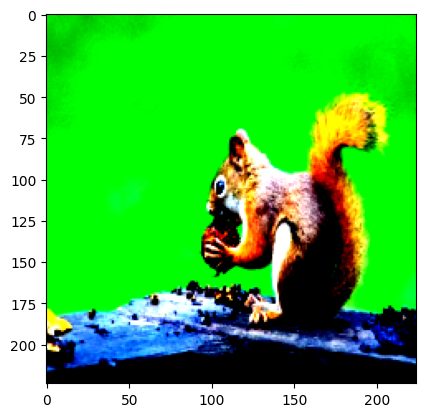

Similar images:


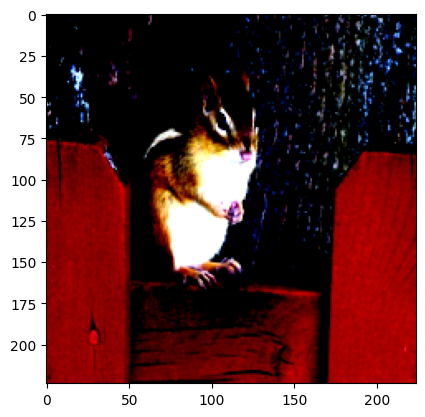

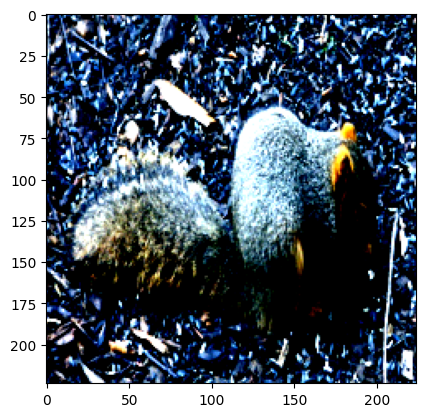

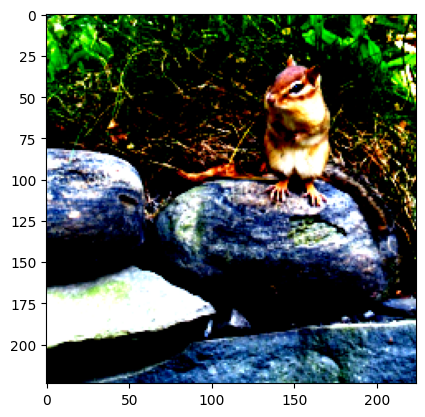

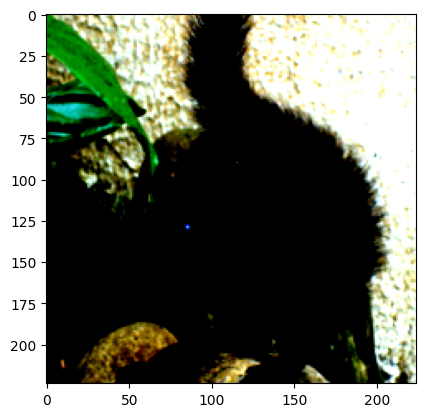

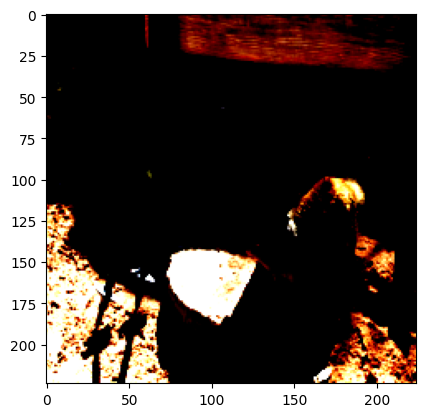

In [39]:
# Find similar images from the data set
from PIL import Image
import matplotlib.pyplot as plt

image = '/content/drive/MyDrive/GMM_Demo/similar_squirrel.jpg'

image_features = extract_features(image, similarity_model)

similarity_batch_size = 30
similarity_dataset = datasets.ImageFolder(train_path, transform = simple_transform)
similarity_dataloader = torch.utils.data.DataLoader(similarity_dataset, batch_size=similarity_batch_size, shuffle=False)

all_features = []

for images, labels in similarity_dataloader:
  output = similarity_model(images.to('cpu'))
  batch_features = output.cpu().detach().numpy()
  batch_features = batch_features.reshape(batch_features.shape[0], -1)
  all_features.extend(batch_features)

all_features = [image_features] + all_features
all_features = np.array(all_features)
similarity_matrix = cosine_similarity(all_features)

similarImageIndices = similarity_matrix[0].argsort()[::-1]

full_image = read_img(image)
similarity_dataset = datasets.ImageFolder(train_path, transform = simple_transform)

print("Original image:")
plt.imshow(full_image.squeeze().permute(1, 2, 0))
plt.show()

print("Similar images:")
for index in range(1, 6):
  similar_img = similarity_dataset[similarImageIndices[index]][0]
  plt.imshow(similar_img.permute(1, 2, 0))
  plt.show()